In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
#from geopy.geocoders import Nominatim
#from geopy.exc import GeocoderTimedOut

import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV,train_test_split , KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:

df_host = pd.read_csv('host_data.csv')
df_loc = pd.read_csv('location_data.csv')
df_pric = pd.read_csv('pricing_data.csv')
df_prop = pd.read_csv('property_data.csv')
df_rev = pd.read_csv('review_data.csv')

In [3]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.isna().sum())

customer_id                   0
host_since                  173
host_response_rate        17193
host_has_profile_pic        173
host_identity_verified      173
dtype: int64
customer_id         0
neighbourhood    9550
latitude            0
longitude           0
city                0
zipcode           894
dtype: int64
customer_id            0
log_price              0
cleaning_fee           0
cancellation_policy    0
dtype: int64
customer_id        0
property_type      0
room_type          0
bedrooms          83
bathrooms        182
accommodates       0
beds             113
dtype: int64
customer_id                 0
number_of_reviews           0
review_scores_rating    15733
first_review            14932
last_review             14896
dtype: int64


In [4]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.shape)
    print(i.head(1))

(69546, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(69546, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(69546, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(69546, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [5]:
df = df_host.merge(df_loc, on='customer_id', how='inner') \
                   .merge(df_pric, on='customer_id', how='inner') \
                   .merge(df_rev, on='customer_id', how='inner') \
                   .merge(df_prop, on='customer_id', how='inner')
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

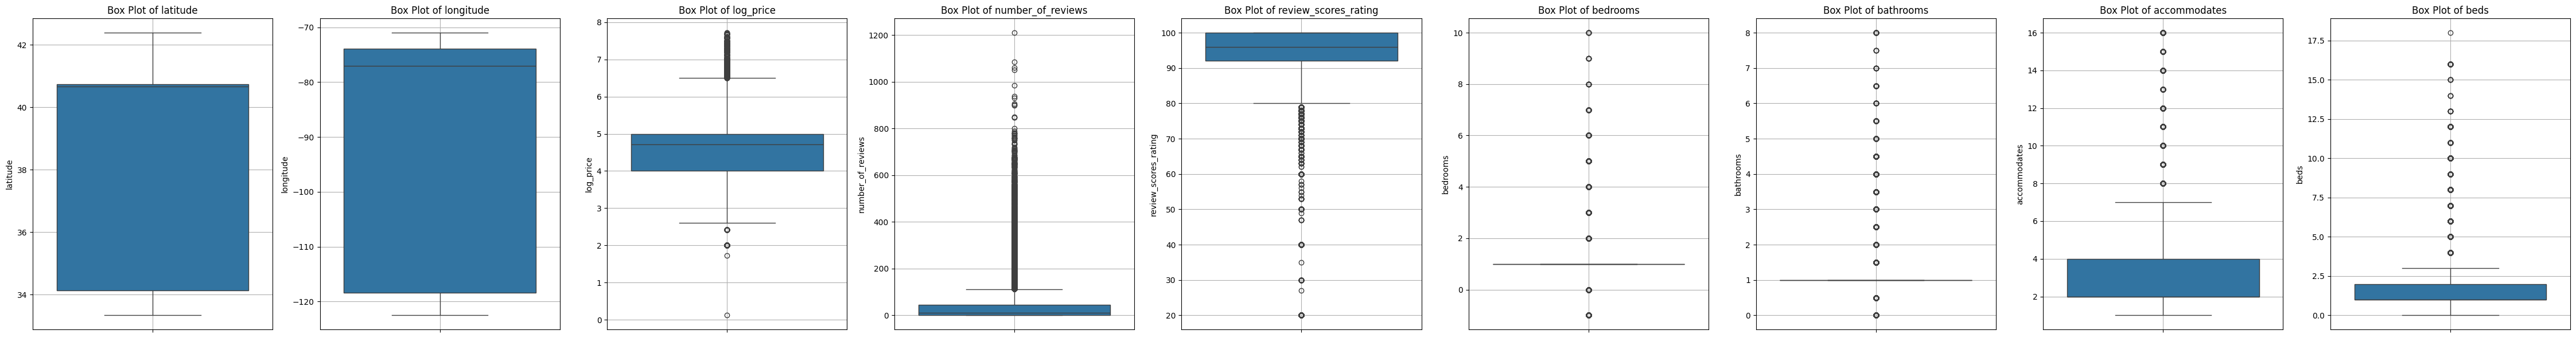

In [6]:
numerical_cols = df.select_dtypes(include=['number']).columns

num_cols = len(numerical_cols)
fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 6))
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')
    ax.set_ylabel(col)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [7]:
cols_to_drop = ['customer_id','host_since','first_review','last_review']
df = df.drop(columns=cols_to_drop, axis = 1)

In [8]:
model_scores = {}
X = df.drop(columns=['log_price'])
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# Assuming X_train and X_test are your features and y_train and y_test are your target variables

# Example preprocessing function
def preprocess_data(X):
    # Convert datetime columns to numerical features
    if 'host_since' in X.columns:
        X['host_since'] = pd.to_datetime(X['host_since']).astype(int) / 10**9  # Convert to seconds since epoch
    if 'first_review' in X.columns:
        X['first_review'] = pd.to_datetime(X['first_review']).astype(int) / 10**9
    if 'last_review' in X.columns:
        X['last_review'] = pd.to_datetime(X['last_review']).astype(int) / 10**9

    # Convert categorical columns to category type
    categorical_cols = ['host_response_rate', 'host_has_profile_pic', 'host_identity_verified', 
                        'neighbourhood', 'city', 'zipcode', 'cancellation_policy', 
                        'property_type', 'room_type']
    
    for col in categorical_cols:
        if col in X.columns:
            X[col] = X[col].astype('category')

    # One-hot encoding for categorical variables
    X = pd.get_dummies(X, drop_first=True)
    
    return X

# Preprocess the data
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

# Now you can proceed with your model training and evaluation
saved_model_name = 'model_xgb_TUNED_No_Feature_No_CoordinatesV2.joblib'

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgb_TUNED = loaded_model
else:
    grid_search = GridSearchCV(xgb.XGBRegressor(enable_categorical=True), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_xgb_TUNED = grid_search.best_estimator_
    joblib.dump(model_xgb_TUNED, saved_model_name)

y_pred = model_xgb_TUNED.predict(X_test)

train_score = model_xgb_TUNED.score(X_train, y_train)
test_score = model_xgb_TUNED.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

params = model_xgb_TUNED.get_xgb_params()

model_scores['XGBoost TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used Parameters': params
}

print(f"Train Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

In [ ]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0.5, 1)
plt.legend()
plt.show()

In [ ]:
best_model = max(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the best model -', best_model)
print(model_scores[best_model]['Train Score']) 
print(model_scores[best_model]['Test Score'])
print(model_scores[best_model]['Used parameters']) 

worst_model = min(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the worst model -', worst_model)
print(model_scores[worst_model]['Train Score']) 
print(model_scores[worst_model]['Test Score'])
print(model_scores[worst_model]['Used parameters']) 